In [6]:
from data import get_data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
data = get_data(512)
batch_size = 32
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

In [8]:
def check(c, img):
    mask = np.zeros((img.shape[0],img.shape[1],1), np.uint8)
    cv2.circle(mask,(c[0],c[1]),c[2],1,10)
    res = cv2.bitwise_and(img, mask)
    return res.sum() >= mask.sum() * 0.4

In [28]:
def detect_course(img):
    img = np.array(img)
    img8 = np.uint8(img * 255)
    course = cv2.cvtColor(img8, cv2.COLOR_RGB2HSV)
#     course = cv2.blur(course, (3, 3))
    lower_pink = np.array([120, 50, 20])
    upper_pink = np.array([180, 256, 256])
    lower_red = np.array([0, 150, 0])
    upper_red = np.array([10, 256, 256])
    mask_pink = cv2.inRange(course, lower_pink, upper_pink)
    mask_red = cv2.inRange(course, lower_red, upper_red)
    mask_course = cv2.bitwise_or(mask_pink, mask_red)
    course = cv2.bitwise_and(course,course, mask=mask_course)
    course = cv2.cvtColor(course, cv2.COLOR_HSV2RGB)
    course = cv2.cvtColor(course, cv2.COLOR_RGB2GRAY)
    _, course = cv2.threshold(course, 50, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
    course = cv2.erode(course, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    course = cv2.dilate(course, kernel)
    course = cv2.medianBlur(course, 5)
    
    return course

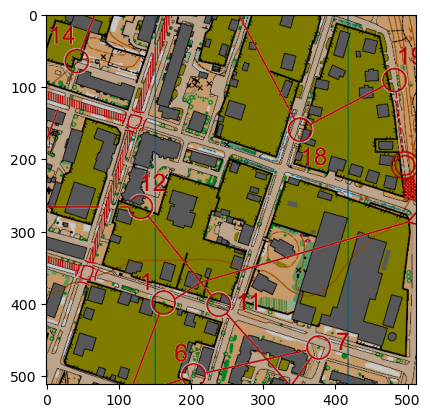

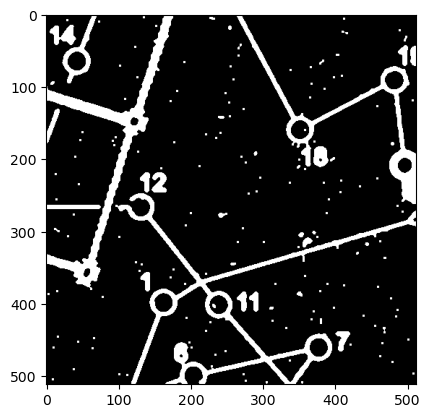

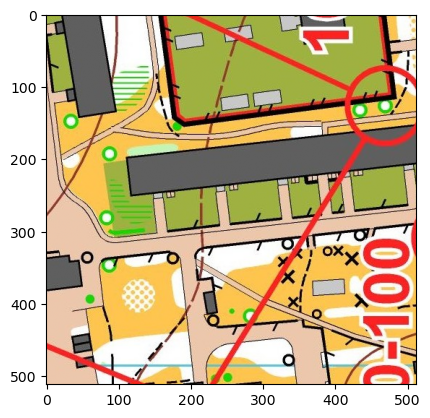

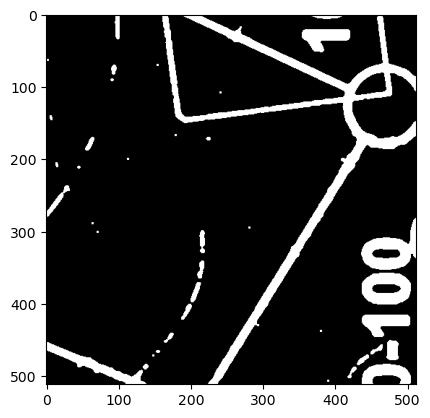

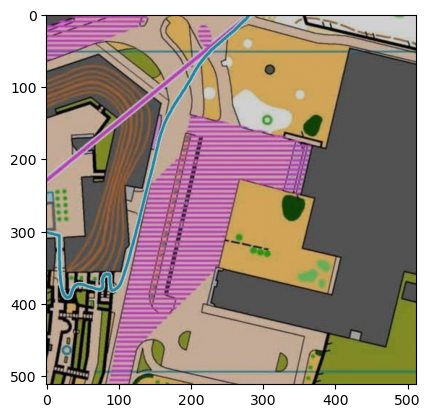

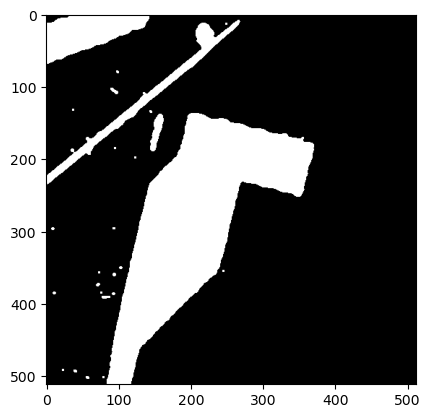

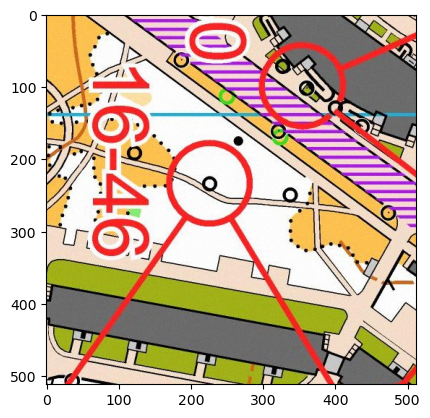

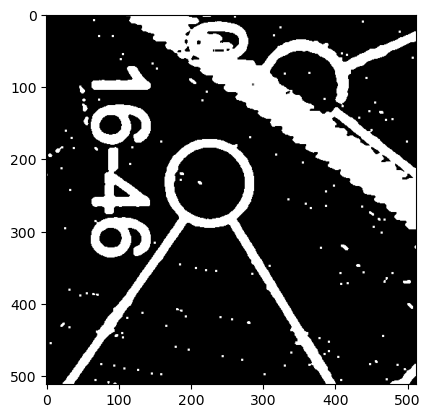

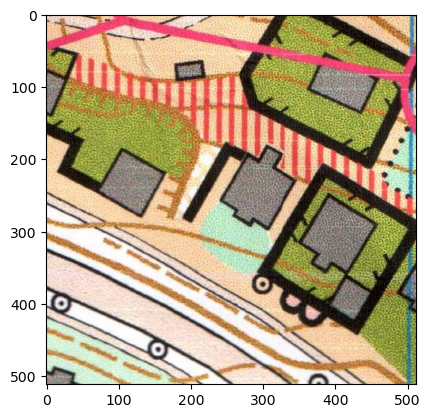

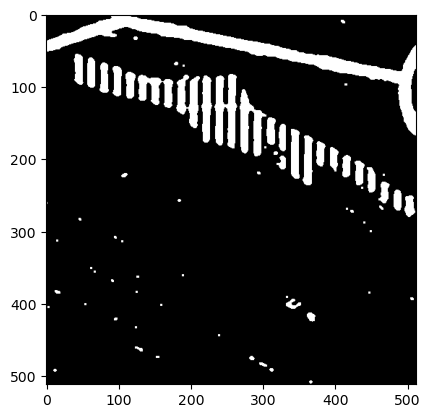

In [31]:
cnt = 0
last_data = None
for data, label in dataloader:
    last_data = data
    course = detect_course(data[0])
    plt.imshow(data[0])
    plt.show()
    plt.imshow(course, cmap='gray')
    plt.show()
    cnt += 1
    if cnt == 5:
        break

In [71]:
def detect_start(course):
    contours,hierarchy = cv2.findContours(course, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    res = np.zeros_like(course)
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.1*cv2.arcLength(cnt, True), True)
        if len(approx) == 3:
            l = np.linalg.norm(approx[0] - approx[1])
            all_sizes_equal = True
            for i in range(3):
                if abs(np.linalg.norm(approx[i] - approx[(i + 1) % 3]) - l) / l > 0.1:
                    all_sizes_equal = False
            if not all_sizes_equal:
                continue
            res = cv2.drawContours(res, [cnt], -1, 255, 1)
            plt.imshow(res)
            plt.show()
            
            return True
    return False

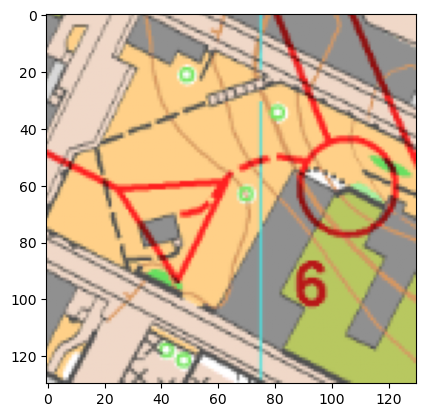

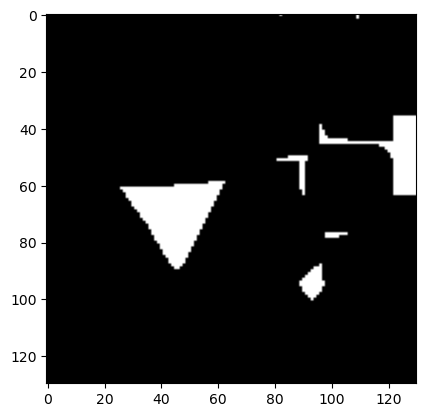

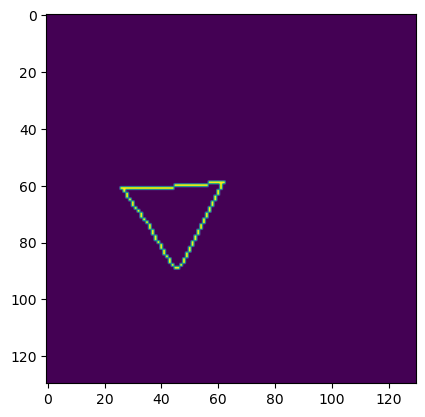

In [72]:
cnt = 0
last_data = None
map = cv2.imread('data/triangle.png')
map = cv2.cvtColor(map, cv2.COLOR_BGR2RGB) / 255    
plt.imshow(map)
plt.show()
course = detect_course(map)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,10))
course = cv2.dilate(course, kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,15))
course = cv2.erode(course, kernel)
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,10))
# course = cv2.dilate(course, kernel)

plt.imshow(course, cmap='gray')
plt.show()
start = detect_start(course)
